In [1]:
from util.gen_utils import *
from util.read_qpcr_plate_class import *

import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.stats import multitest
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
#Set fig export settings

#For editable text. Except latex text is still shapes sadly
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
font = {'size' : 5}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}

matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
matplotlib.rc('figure', **fig)

%matplotlib inline

# Figure 2 

## Load data
4 independent experiments that fully run through the semi-automated pipeline. Results quantified in 5 qPCR plates. 
Each experiment laid out samples in a checkerboard pattern to quantify cross-contamination in addition to measuring end-point RNA rescue 

* Load in class defined for qPCR plate. 
* For each plate specify which wells correspond to which condition in plate layout. The length of each value in plate layout indicates the number of technical replicates. 

In [3]:
#Fig 2B data
plate_layout_fig2b_1215 = {'p1_pre_refrigeration' : [get_well_list("ABCDEFGH", np.arange(1,13,2)),
                                get_well_list("ABCDEFGH", np.arange(2,13,2))],
                     'p1_post_refrigeration' : [get_well_list("ABCDEFGH", np.arange(13,25,2)),
                                get_well_list("ABCDEFGH", np.arange(14,25,2))],
                     'p2' : [get_well_list("IKMO", np.arange(3,13,4)) + get_well_list("JLNP", np.arange(1,13,4)), 
                                get_well_list("IKMO", np.arange(4,13,4)) + get_well_list("JLNP", np.arange(2,13,4))],
                     'pc' : [[("I", 17)], [("I", 18)]], 'ntc' : [[("I", 19)], [("I", 20)]]}

plate_layout_fig2b_0109 = {'p1_pre_refrigeration' : [get_well_list("ACEG", np.arange(1,13,4)) + get_well_list("BDFH", np.arange(3,13,4)), 
                                get_well_list("ACEG", np.arange(2,13,4)) + get_well_list("BDFH", np.arange(4,13,4))],
                     'p1_post_refrigeration' : [get_well_list("ACEG", np.arange(13,25,4)) + get_well_list("BDFH", np.arange(15,25,4)), 
                                get_well_list("ACEG", np.arange(14,25,4)) + get_well_list("BDFH", np.arange(16,25,4))],
                     'p2' : [get_well_list("IKMO", np.arange(1,13,4)) + get_well_list("JLNP", np.arange(3,13,4)), 
                                get_well_list("IKMO", np.arange(2,13,4)) + get_well_list("JLNP", np.arange(4,13,4))],
                     'pc' : [[("I", 17)], [("I", 18)]], 'ntc' : [[("I", 19)], [("I", 20)]]}

#Fig 2C data layout
plate_layout_fig2c_0111_0115 = {'spiked' :  [get_well_list("ACEG", np.arange(1,25,4)) + get_well_list("BDFH", np.arange(3, 25, 4)), 
                                      get_well_list("ACEG", np.arange(2,25,4)) + get_well_list("BDFH", np.arange(4, 25, 4))],
                            'ntc_xc' : [get_well_list("ACEG", np.arange(3,25,4)) + get_well_list("BDFH", np.arange(1, 25, 4)), 
                                      get_well_list("ACEG", np.arange(4,25,4)) + get_well_list("BDFH", np.arange(2, 25, 4))],
                          'pc' : [[("I", 5)], [("I", 6)]], 'ntc' : [[("I", 7)], [("I", 8)]]}

#Fig 2D data layout
plate_layout_fig2d_0116 = {'0109_spiked' : [get_well_list("ACEG", np.arange(1,25,4)) + get_well_list("BDFH", np.arange(3,25,4))],
                            '0111_spiked' : [get_well_list("ACEG", np.arange(2,25,4)) + get_well_list("BDFH", np.arange(4,25,4))],
                            '0115_spiked' : [get_well_list("IKMO", np.arange(1,25,4)) + get_well_list("JLNP", np.arange(3,25,4))],
                            'manual1_spiked' : [get_well_list("I", np.arange(2,17, 2))],
                            'manual2_spiked' : [get_well_list("J", np.arange(2,17, 2))],
                            'manual3_spiked' : [get_well_list("K", np.arange(2,17, 2))],
                            'pc' : [[("I", 18)], [("J", 18)], [("K", 18)]],
                            'ntc' : [[("L", 18)], [("M", 18)]]
                          }

In [4]:
#Load data
ntc_vals = []
figdata = {}

figdata['fig2b'] = [qpcr_plate(read_qpcr_data("../data/fig2/fig2B_121518.xlsx"), plate_layout_fig2b_1215), 
                    qpcr_plate(read_qpcr_data("../data/fig2/fig2B_010919.xlsx"), plate_layout_fig2b_0109)]

figdata['fig2c'] = [qpcr_plate(read_qpcr_data("../data/fig2/fig2C_011119.xlsx"), plate_layout_fig2c_0111_0115),
                    qpcr_plate(read_qpcr_data("../data/fig2/fig2C_011519.xlsx"), plate_layout_fig2c_0111_0115)]

figdata['fig2d'] = [qpcr_plate(read_qpcr_data("../data/fig2/fig2D_FullComparison.xlsx"), plate_layout_fig2d_0116)] #Only 1 tech rep per well for this layout

figdata['ntc'] = [qpcr_plate(read_qpcr_data("../data/supp_ERCC54_oligoQC_100118.xlsx"), {'ntc' : [get_well_list("H", np.arange(1,13))]})]

/Users/miramou/Documents/Grad/Lab/Manuscripts/OT/figs/util/read_qpcr_plate_class.py:35: RuntimeWarning: Mean of empty slice
  self.data[label] = np.nanmean(self.data_tech_reps[label], axis=1) #if (has_non_nans and not_empty) else np.nan
/Users/miramou/miniconda3/envs/gen_comp/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [5]:
min_ntc, all_ntc = get_min_ntc_axs_plates(figdata)
figdata = update_detection_mask(figdata, min_ntc)

## 2B

In [6]:
plate_n = 1
for plate in figdata['fig2b']:
    tmp_df = plate.get_plotting_df({'p1_pre_refrigeration' : "Pre-", 
                                    'p1_post_refrigeration' : "Post-", 
                                    'p2' : "Control"}, is_dCt = False)
    tmp_df.insert(tmp_df.shape[1], "plate", "Trial " + str(plate_n))
    
    fig2b_plot_df = tmp_df if plate_n == 1 else pd.concat((fig2b_plot_df, tmp_df), axis=0, ignore_index = True)
    plate_n += 1

fig2b_plot_df.insert(fig2b_plot_df.shape[1], "step_plate", fig2b_plot_df.step + fig2b_plot_df.plate)    
fig2b_plot_df.head()

,val,step,plate,step_plate
0,23.372991,Pre-,Trial 1,Pre-Trial 1
1,20.332667,Pre-,Trial 1,Pre-Trial 1
2,20.552727,Pre-,Trial 1,Pre-Trial 1
3,19.906238,Pre-,Trial 1,Pre-Trial 1
4,19.633207,Pre-,Trial 1,Pre-Trial 1


In [7]:
fig2b_post_control_combos = [("ControlTrial " + str(n), "Post-Trial " + str(n)) for n in range(1, len(figdata['fig2b'])+1)]

# 1-sample Wilcoxon test to check for difference between pre and post refrigeration
# 2-sample Mann-Whitney to check for difference between post-refrigeration and control. Check if C_t of post-refrigeration is greater than that of control indicating RNA loss
pvals_pre_post = []
for plate in figdata['fig2b']:
    pvals_pre_post.append(scipy.stats.wilcoxon(x = plate.get_d_or_ddCt('p1_post_refrigeration', 'p1_pre_refrigeration', is_ddCt = False)).pvalue)

pvals_pre_post_adj = multitest.multipletests(pvals_pre_post, method = 'bonferroni')
pvals_post_control, pvals_post_control_adj = test_and_adj(fig2b_post_control_combos, fig2b_plot_df, "step_plate", "val", alternative = "less", use_ttest = False) 

for plate_n in range(len(figdata['fig2b'])):
    print("Trial %d:" % (plate_n +1))
    print("Wilcoxon test paired samples (pre/post refrigeration) pval = %f, adj_pval = %f" % (pvals_pre_post[plate_n], pvals_pre_post_adj[1][plate_n]))
    print("MW test (post fridge/control) pval = %f, adj_pval = %f" % (list(pvals_post_control.values())[plate_n], pvals_post_control_adj[1][plate_n]))

Trial 1:
Wilcoxon test paired samples (pre/post refrigeration) pval = 0.215674, adj_pval = 0.431349
MW test (post fridge/control) pval = 0.554632, adj_pval = 1.000000
Trial 2:
Wilcoxon test paired samples (pre/post refrigeration) pval = 0.544590, adj_pval = 1.000000
MW test (post fridge/control) pval = 0.671234, adj_pval = 1.000000


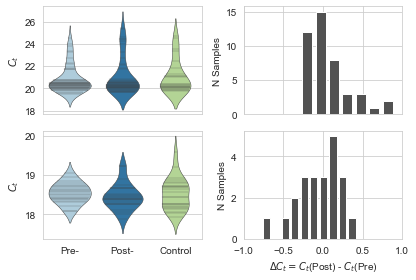

In [8]:
fig, ax = plt.subplots(2,2, sharex = 'col')

plate_n = 0
for plate in figdata['fig2b']:
    sns.violinplot(x = 'step', y = 'val', data = fig2b_plot_df.loc[fig2b_plot_df.plate == "Trial " + str(plate_n+1)], inner = 'stick', palette = 'Paired', ax = ax[plate_n, 0])
    ax[plate_n, 0].set_ylabel(r"$C_t$")
    ax[plate_n, 0].set_xlabel("")
    
    ax[plate_n, 1].hist(plate.get_d_or_ddCt('p1_post_refrigeration', 'p1_pre_refrigeration', is_ddCt = False), color = '#525252', rwidth = 0.75)
    ax[plate_n, 1].set_ylabel("N Samples")
    ax[plate_n, 1].set_xlim([-1, 1])
    
    if plate_n == 1:
        ax[plate_n, 1].set_xlabel(r"$\Delta C_t = C_t$(Post) - $C_t $(Pre)")
    plate_n += 1

fig.tight_layout()

plt.savefig("../figs/fig_subparts/fig2/fig2b.pdf", bbox_inches='tight', transparent = True, dpi = 300)

# 2C
* XC

In [9]:
plate_n = 1
for plate in figdata['fig2c']:
    tmp_df = plate.get_plotting_df({'ntc_xc' : "Trial " + str(plate_n)}, only_detected = False, is_dCt = False)
    pc = plate.get_plotting_df({'pc' : "Trial " + str(plate_n)}, only_detected = False, is_dCt = False)

    pc.insert(pc.shape[1], "is_pc", True)
    tmp_df.insert(tmp_df.shape[1], "is_pc", False)
    tmp_df = pd.concat((tmp_df, pc), axis = 0, ignore_index = True)
        
    fig2c_plot_df = tmp_df if plate_n == 1 else pd.concat((fig2c_plot_df, tmp_df), axis=0, ignore_index = True)
    plate_n += 1

fig2c_plot_df = pd.concat((fig2c_plot_df, pd.DataFrame({'val' : all_ntc, 'step' : 'NTC', 'is_pc' : False})), axis = 0, ignore_index=True)
fig2c_plot_df.head()

,val,step,is_pc
0,36.490250,Trial 1,False
1,NaN,Trial 1,False
2,37.005196,Trial 1,False
3,38.027368,Trial 1,False
4,35.065325,Trial 1,False


In [10]:
fig2c_combos = [("NTC", "Trial " + str(n)) for n in range(1, len(figdata["fig2c"]) + 1)]
pvals_xc, pvals_xc_adj = test_and_adj(fig2c_combos, fig2c_plot_df, "step", "val", "greater", use_ttest = False)

i = 0
for trial_combo, pval in pvals_xc.items():
    print("For trial %d, MW-test to check for difference between known NTC and NTCs that went through pipeline: pval = %f, pval_adj = %f" % (plate_n, pval, pvals_xc_adj[1][i]))
    i += 1

For trial 3, MW-test to check for difference between known NTC and NTCs that went through pipeline: pval = 0.084048, pval_adj = 0.168096
For trial 3, MW-test to check for difference between known NTC and NTCs that went through pipeline: pval = 0.050265, pval_adj = 0.100531


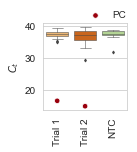

In [11]:
colors_2c = ['#fdb863', '#e66101', '#b2df8a']
plt.figure(figsize = (1.5, 1.6))

sns.boxplot(x = 'step', y = 'val', data = fig2c_plot_df.loc[~(fig2c_plot_df.is_pc)], fliersize = 2, palette = colors_2c)
sns.scatterplot(x = 'step', y = 'val', size = 1, data = fig2c_plot_df.loc[(fig2c_plot_df.is_pc)], sizes = (30,30), color = '#99000d', legend = False, label = "PC")
plt.tick_params('x', labelrotation=90)
plt.xlabel("")
plt.ylabel(r"$C_t$")
plt.legend(loc="upper right", ncol=1, frameon=0,bbox_to_anchor=(1.1, 1.25))
plt.savefig("../figs/fig_subparts/fig2/fig2c_right.pdf", bbox_inches='tight', transparent = True, dpi = 300)

# 2D
* Comparison of manual to semi-auto

In [12]:
fig2d_plot_df = figdata['fig2d'][0].get_plotting_df({'manual1_spiked' : "Manual Trial 1", "manual2_spiked" : "Manual Trial 2", "manual3_spiked" : "Manual Trial 3",
                                                    '0109_spiked' : 'SA Trial 1', '0111_spiked' : 'SA Trial 2', '0115_spiked' : 'SA Trial 3'},
                                                   is_dCt = True)

fig2d_plot_df.insert(fig2d_plot_df.shape[1], 'group', "Semi-Automated")
fig2d_plot_df.loc[fig2d_plot_df.step.str.contains("Manual"), "group"] = "Manual" 
fig2d_plot_df.head()

,val,step,group
0,0.666741,Manual Trial 1,Manual
1,1.176370,Manual Trial 1,Manual
2,0.899638,Manual Trial 1,Manual
3,1.279530,Manual Trial 1,Manual
4,1.114286,Manual Trial 1,Manual


In [13]:
#One-sided Test - Want to know if sig less RNA is recovered via SA technique than manual
manual_trials = fig2d_plot_df.loc[fig2d_plot_df.group == "Manual"].step.unique()
sa_trials = fig2d_plot_df.loc[fig2d_plot_df.group == "Semi-Automated"].step.unique()
fig2d_combos = list(product(manual_trials, sa_trials)) + list(combinations(manual_trials, 2)) + list(combinations(sa_trials, 2)) +  [("Grouped Manual", "Grouped SA")]

pvals_2d, pvals_2d_adj = test_and_adj(fig2d_combos, fig2d_plot_df, "step", "val", "less", use_ttest = False)

i = 0
for trial_combo, pval in pvals_2d.items():
    print("%s and %s: Pval = %e, Adj Pval = %e, Sig = %s" % (trial_combo[0], trial_combo[1], pval, pvals_2d_adj[1][i], pvals_2d_adj[0][i]))
    i += 1
    

Manual Trial 1 and SA Trial 1: Pval = 6.303100e-06, Adj Pval = 1.008496e-04, Sig = True
Manual Trial 1 and SA Trial 2: Pval = 3.302754e-02, Adj Pval = 5.284407e-01, Sig = False
Manual Trial 1 and SA Trial 3: Pval = 3.664472e-06, Adj Pval = 5.863156e-05, Sig = True
Manual Trial 2 and SA Trial 1: Pval = 1.239634e-04, Adj Pval = 1.983415e-03, Sig = True
Manual Trial 2 and SA Trial 2: Pval = 8.860631e-01, Adj Pval = 1.000000e+00, Sig = False
Manual Trial 2 and SA Trial 3: Pval = 7.801387e-06, Adj Pval = 1.248222e-04, Sig = True
Manual Trial 3 and SA Trial 1: Pval = 7.970753e-01, Adj Pval = 1.000000e+00, Sig = False
Manual Trial 3 and SA Trial 2: Pval = 9.999922e-01, Adj Pval = 1.000000e+00, Sig = False
Manual Trial 3 and SA Trial 3: Pval = 3.583297e-01, Adj Pval = 1.000000e+00, Sig = False
Manual Trial 1 and Manual Trial 2: Pval = 1.938021e-03, Adj Pval = 3.100833e-02, Sig = True
Manual Trial 1 and Manual Trial 3: Pval = 4.695528e-04, Adj Pval = 7.512846e-03, Sig = True
Manual Trial 2 and 

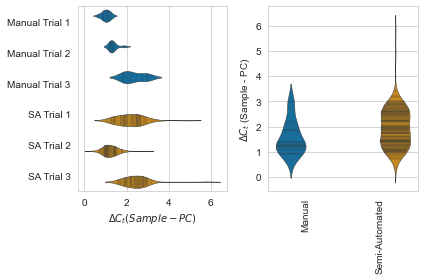

In [14]:
fig, ax = plt.subplots(1, 2)

sns.violinplot(x = 'val', y = 'step', hue = 'group', inner = 'stick', data = fig2d_plot_df, palette = 'colorblind', ax = ax[0])
ax[0].set_ylabel("")
ax[0].set_xlabel(r"$\Delta C_t (Sample - PC)$")
ax[0].legend().set_visible(False)
sns.violinplot(x = 'group', y = 'val', hue = 'group', inner = 'stick', data = fig2d_plot_df, palette = 'colorblind', ax = ax[1])
ax[1].set_xlabel("")
ax[1].tick_params('x', labelrotation=90)
ax[1].set_ylabel(r"$\Delta C_t$ (Sample - PC)")
ax[1].legend().set_visible(False)
fig.tight_layout()
plt.savefig('../figs/fig_subparts/fig2/fig2d.pdf', bbox_inches = 'tight', transparent = True, dpi = 300)

# Supp

## Fig 1

In [26]:
plate_layout_qc = {10000 : [get_well_list("E", [1]), get_well_list("F", [1]), get_well_list("G", [1])],
                   5000 : [get_well_list("E", [2]), get_well_list("F", [2]), get_well_list("G", [2])],
                   2500 : [get_well_list("E", [3]), get_well_list("F", [3]), get_well_list("G", [3])],
                   1250 : [get_well_list("E", [4]), get_well_list("F", [4]), get_well_list("G", [4])],
                   625 : [get_well_list("E", [5]), get_well_list("F", [5]), get_well_list("G", [5])],
                   312.5 : [get_well_list("E", [6]), get_well_list("F", [6]), get_well_list("G", [6])],
                   156 : [get_well_list("E", [7]), get_well_list("F", [7]), get_well_list("G", [7])],
                   78 : [get_well_list("E", [8]), get_well_list("F", [8]), get_well_list("G", [8])],
                   39 : [get_well_list("E", [9]), get_well_list("F", [9]), get_well_list("G", [9])],
                   19.5 : [get_well_list("E", [10]), get_well_list("F", [10]), get_well_list("G", [10])],
                   10 : [get_well_list("E", [11]), get_well_list("F", [11]), get_well_list("G", [11])],
                   5 : [get_well_list("E", [12]), get_well_list("F", [12]), get_well_list("G", [12])],
                          }

supp_fig1 = qpcr_plate(read_qpcr_data("../data/supp_ERCC54_oligoQC_100118.xlsx"), plate_layout_qc)

In [27]:
pg = np.array(list(supp_fig1.data.keys()))
ct = np.array(list(supp_fig1.data.values()))[:, 0] 
lin_fit = np.poly1d(np.polyfit(np.log2(pg), ct, deg=1))

/Users/miramou/miniconda3/envs/gen_comp/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


Text(0.5, 0, 'Oligo (pg)')

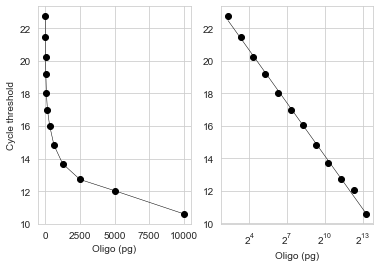

In [28]:
plt.figure()
plt.subplot(121)
plt.scatter(pg, ct, color = 'k')
plt.plot(pg, ct, color = 'k')
plt.xlabel("Oligo (pg)")
plt.ylabel("Cycle threshold")
ax = plt.subplot(122)
ax.set_xscale('log', basex=2)
plt.scatter(pg, ct, color = 'k')
plt.plot(pg, lin_fit(np.log2(pg)), color = 'k')
plt.xlabel("Oligo (pg)")
#plt.savefig("fig_subparts/supp/supp1.pdf", transparent = True, bbox_inches = 'tight')